# Data Pre-processing

In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import gzip
import matplotlib.pyplot as plt

In [6]:
f = gzip.GzipFile('data_processed.npy.gz', "r")
data = np.load(f, allow_pickle=True)
f.close()

f = gzip.GzipFile('results_processed.npy.gz', "r")
labels = np.load(f, allow_pickle=True)
f.close()

data = data[0:500000]
labels = labels[0:500000] + 1

#10% as the test data
Xtr, Xts, ytr, yts = train_test_split(data, labels, test_size=0.10)


In [7]:
#getting the right dtypes for the tensors
x_tr = torch.from_numpy(Xtr)
x_tr = x_tr.type(torch.FloatTensor)
y_tr = torch.from_numpy(ytr)
y_tr = y_tr.type(torch.LongTensor)
x_ts = torch.from_numpy(Xts)
x_ts = x_ts.type(torch.FloatTensor)
y_ts = torch.from_numpy(yts)
y_ts = y_ts.type(torch.LongTensor)

In [8]:
#turning into the loader class
traindata = torch.utils.data.TensorDataset(x_tr, y_tr)
trainloader = torch.utils.data.DataLoader(
    traindata,
    batch_size = 100000
)

testdata = torch.utils.data.TensorDataset(x_ts, y_ts)
testloader = torch.utils.data.DataLoader(
    testdata,
    batch_size = 10000
)

# Training
## Shallow Network
Running the cell below trains the shallow network and stores the results

In [7]:
#simple neural network
n_in = 768
n_out = 3
learning_rate = 0.001
K = 770
P = 1.0
epochs = 80

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_in, K) 
        torch.nn.init.kaiming_uniform_(self.fc1.weight) #He initialization
        self.fc2 = nn.Linear(K, n_out)
        torch.nn.init.kaiming_uniform_(self.fc2.weight) #He initialization

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        return x

net = Net().to(device)
#criterion = torch.nn.MSELoss()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

In [ ]:
#baseline
traccs = []
tsaccs = []
for epoch in range(epochs):
    correct = 0
    size = 0
    net.train()
    for b, (x, y) in enumerate(trainloader):
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad() 
        output = net(x)
        #print(output)
        #acu += (output.argmax(1) == y).float().sum().item()
        cor = (output.argmax(1) == y).float().sum().item()

        correct += cor
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

        size += len(x)

    #accs.append(100 * (acu / len(y_tr)))
    traccs.append((100 * correct) / size)
    net.eval()
    correct = 0
    size = 0
    with torch.no_grad():
        for b, (x, y) in enumerate(testloader):
            x = x.to(device)
            y = y.to(device)

            optimizer.zero_grad() 
            output = net(x)
            #print(output)
            #acu += (output.argmax(1) == y).float().sum().item()
            cor = (output.argmax(1) == y).float().sum().item()

            correct += cor
            size += len(x)

        #accs.append(100 * (acu / len(y_tr)))
        tsaccs.append((100 * correct) / size)

Code to plot the results

In [ ]:
print("max training accuracy: ", max(traccs))
print("max testing accuracy: ", max(tsaccs))
lab = "training accuracy"
plt.figure(1)
plt.plot(traccs, label=lab)
plt.title("Change in Training Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
lab = "testing accuracy"
plt.figure(2)
plt.plot(tsaccs, label=lab)
plt.title("Change in Testing Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

## Deep Network

In [8]:
#deep neural network
n_in = 768
n_out = 3
learning_rate = 0.001
P = 1.0
epochs = 80

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_in, 770) 
        torch.nn.init.kaiming_uniform_(self.fc1.weight) #He initialization
        self.fc2 = nn.Linear(770, 700)
        torch.nn.init.kaiming_uniform_(self.fc2.weight) #He initialization
        self.fc3 = nn.Linear(700, 600) 
        torch.nn.init.kaiming_uniform_(self.fc3.weight) #He initialization
        self.fc4 = nn.Linear(600, 500)
        torch.nn.init.kaiming_uniform_(self.fc4.weight) #He initialization
        self.fc5 = nn.Linear(500, 400) 
        torch.nn.init.kaiming_uniform_(self.fc5.weight) #He initialization
        self.fc6 = nn.Linear(400, 300)
        torch.nn.init.kaiming_uniform_(self.fc6.weight) #He initialization
        self.fc7 = nn.Linear(300, 200) 
        torch.nn.init.kaiming_uniform_(self.fc7.weight) #He initialization
        self.fc8 = nn.Linear(200, 100)
        torch.nn.init.kaiming_uniform_(self.fc8.weight) #He initialization
        self.fc9 = nn.Linear(100, 50) 
        torch.nn.init.kaiming_uniform_(self.fc9.weight) #He initialization
        self.fc10 = nn.Linear(50, n_out)
        torch.nn.init.kaiming_uniform_(self.fc10.weight) #He initialization

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = F.relu(self.fc7(x))
        x = F.relu(self.fc8(x))
        x = F.relu(self.fc9(x))
        x = F.sigmoid(self.fc10(x))
        return x

net = Net().to(device)
#criterion = torch.nn.MSELoss()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

In [ ]:
traccsd = []
tsaccsd = []
for epoch in range(epochs):
    correct = 0
    size = 0
    net.train()
    for b, (x, y) in enumerate(trainloader):
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad() 
        output = net(x)
        #print(output)
        #acu += (output.argmax(1) == y).float().sum().item()
        cor = (output.argmax(1) == y).float().sum().item()

        correct += cor
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

        size += len(x)

    #accs.append(100 * (acu / len(y_tr)))
    traccsd.append((100 * correct) / size)
    net.eval()
    correct = 0
    size = 0
    with torch.no_grad():
        for b, (x, y) in enumerate(testloader):
            x = x.to(device)
            y = y.to(device)

            optimizer.zero_grad() 
            output = net(x)
            #print(output)
            #acu += (output.argmax(1) == y).float().sum().item()
            cor = (output.argmax(1) == y).float().sum().item()

            correct += cor
            size += len(x)

        #accs.append(100 * (acu / len(y_tr)))
        tsaccsd.append((100 * correct) / size)

In [ ]:
print("max training accuracy: ", max(traccsd))
print("max testing accuracy: ", max(tsaccsd))
lab = "training accuracy"
plt.figure(1)
plt.plot(traccsd, label=lab)
plt.title("Change in Training Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
lab = "tessting accuracy"
plt.figure(2)
plt.plot(tsaccsd, label=lab)
plt.title("Change in Testing Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

# Data Augmentation
## World View

In [8]:
def worldview(dataset):
    """
    args:
    dataset: Dataset
   
    returns: 
    context_dataset: List
    """
    worldview_dataset = []
    
    for item in dataset:
        image = item[0]
        label = item[1]
        chessboard_black = torch.reshape(image, (8, 8, 12))
        chessboard_black = chessboard_black.flip(0)
        chessboard_black = chessboard_black.flip(2)
        chessboard_black = torch.reshape(chessboard_black, (768,))
        
        temp = torch.cat((image, chessboard_black))
        
        worldview_dataset.append((temp, label))
    
    return worldview_dataset

In [9]:
dataset = worldview(traindata)

trainloader = torch.utils.data.DataLoader(
    dataset,
    batch_size = 100000
)

dataset = worldview(testdata)

testloader = torch.utils.data.DataLoader(
    dataset,
    batch_size = 100000
)

In [11]:
#simple neural network
n_in = 1536
n_out = 3
learning_rate = 0.001
K = 1550
P = 1.0
epochs = 80

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_in, K) 
        torch.nn.init.kaiming_uniform_(self.fc1.weight) #He initialization
        self.fc2 = nn.Linear(K, n_out)
        torch.nn.init.kaiming_uniform_(self.fc2.weight) #He initialization

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        return x

net = Net().to(device)
#criterion = torch.nn.MSELoss()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

max training accuracy:  88.64066666666666
max testing accuracy:  86.576


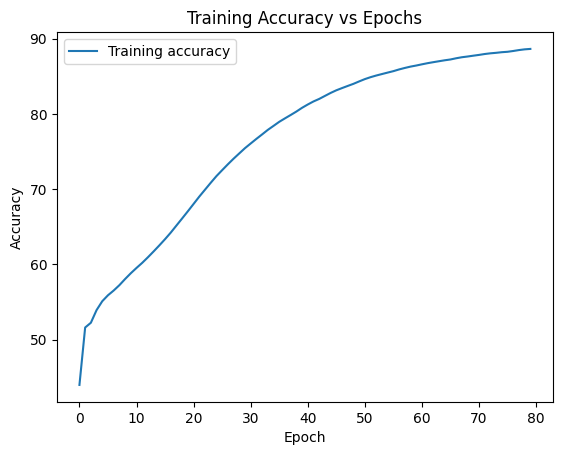

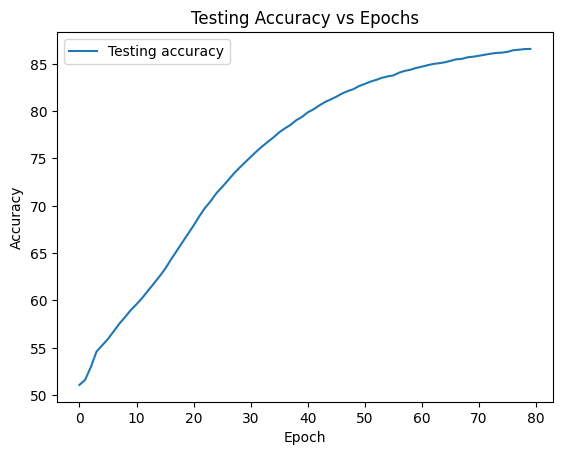

In [12]:
traccs_wv = []
tsaccs_wv = []
for epoch in range(epochs):
    correct = 0
    size = 0
    net.train()
    for b, (x, y) in enumerate(trainloader):
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad() 
        output = net(x)
        #print(output)
        #acu += (output.argmax(1) == y).float().sum().item()
        cor = (output.argmax(1) == y).float().sum().item()

        correct += cor
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

        size += len(x)

    #accs.append(100 * (acu / len(y_tr)))
    traccs_wv.append((100 * correct) / size)
    net.eval()
    correct = 0
    size = 0
    with torch.no_grad():
        for b, (x, y) in enumerate(testloader):
            x = x.to(device)
            y = y.to(device)

            optimizer.zero_grad() 
            output = net(x)
            #print(output)
            #acu += (output.argmax(1) == y).float().sum().item()
            cor = (output.argmax(1) == y).float().sum().item()

            correct += cor
            size += len(x)

        #accs.append(100 * (acu / len(y_tr)))
        tsaccs_wv.append((100 * correct) / size)


max training accuracy:  88.64066666666666
max testing accuracy:  86.576


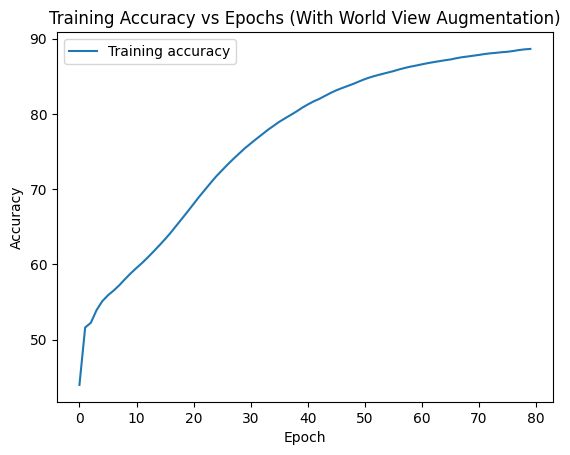

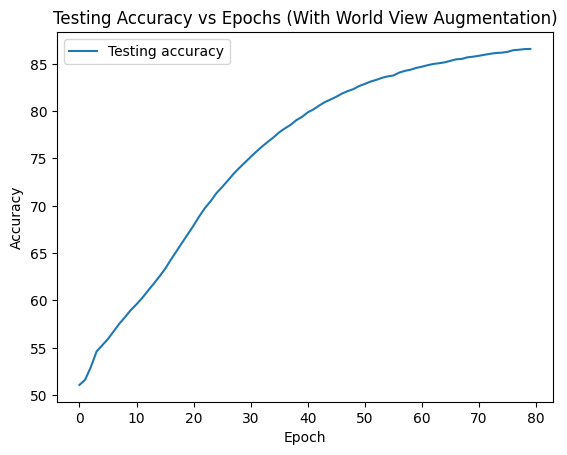

In [17]:
print("max training accuracy: ", max(traccs_wv))
print("max testing accuracy: ", max(tsaccs_wv))
lab = "Training accuracy"
plt.figure(1)
plt.plot(traccs_wv, label=lab)
plt.title("Training Accuracy vs Epochs (With World View Augmentation)")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
lab = "Testing accuracy"
plt.figure(2)
plt.plot(tsaccs_wv, label=lab)
plt.title("Testing Accuracy vs Epochs (With World View Augmentation)")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

## Context

In [13]:
def context(dataset):
    """
    args:
    dataset: Dataset of tensors
   
    returns: 
    context_dataset: Dataset
    """
    context_dataset = []
        
    second_move = False
    # the starting board is the first element of the dataset
    starting_board = dataset[0][0]
    
    for i in range(len(dataset)):
        temp = []
        image, label = dataset[i]
        if torch.equal(image, starting_board):
            for j in range(3):
                temp.append(starting_board.clone())
                second_move = True
        elif second_move:
            for j in range(2):
                temp.append(starting_board.clone())
            temp.append(image)
            second_move = False
        else:
            for j in range(3):
                temp.append(dataset[i+j-2][0].clone())
                
        temp = torch.cat(temp)
        context_dataset.append(temp)
            
    context_dataset = torch.stack(context_dataset)
    new_dataset = torch.utils.data.TensorDataset(context_dataset, dataset[:][1])        
    
    return new_dataset

In [14]:
dataset = context(traindata)

trainloader = torch.utils.data.DataLoader(
    dataset,
    batch_size = 100000
)

dataset = context(testdata)

testloader = torch.utils.data.DataLoader(
    dataset,
    batch_size = 100000
)

In [15]:
#simple neural network
n_in = 2304
n_out = 3
learning_rate = 0.001
K = 2310
P = 1.0
epochs = 80

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_in, K) 
        torch.nn.init.kaiming_uniform_(self.fc1.weight) #He initialization
        self.fc2 = nn.Linear(K, n_out)
        torch.nn.init.kaiming_uniform_(self.fc2.weight) #He initialization

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        return x

net = Net().to(device)
#criterion = torch.nn.MSELoss()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

max training accuracy:  89.94688888888889
max testing accuracy:  76.65


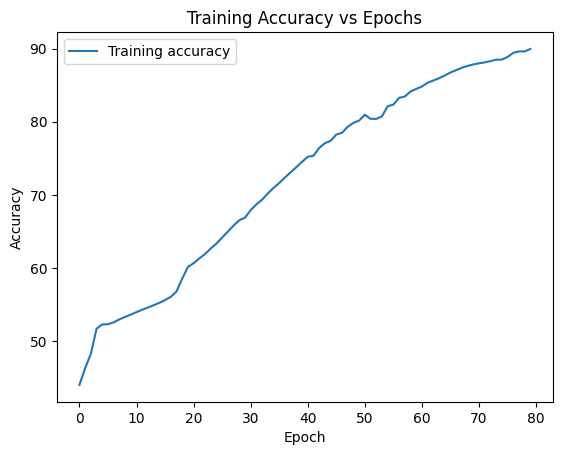

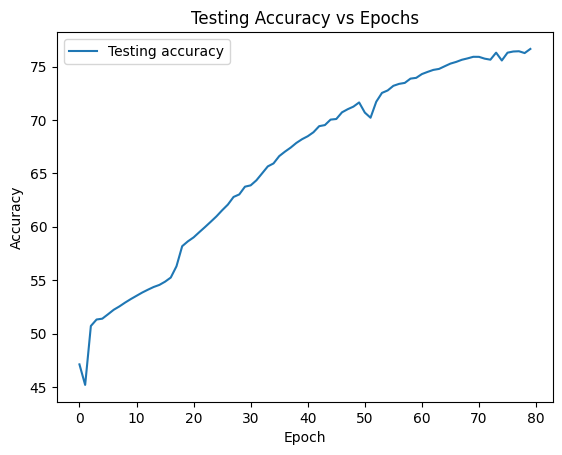

In [16]:
#baseline
traccs_c = []
tsaccs_c = []
for epoch in range(epochs):
    correct = 0
    size = 0
    net.train()
    for b, (x, y) in enumerate(trainloader):
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad() 
        output = net(x)
        #print(output)
        #acu += (output.argmax(1) == y).float().sum().item()
        cor = (output.argmax(1) == y).float().sum().item()

        correct += cor
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

        size += len(x)

    #accs.append(100 * (acu / len(y_tr)))
    traccs_c.append((100 * correct) / size)
    net.eval()
    correct = 0
    size = 0
    with torch.no_grad():
        for b, (x, y) in enumerate(testloader):
            x = x.to(device)
            y = y.to(device)

            optimizer.zero_grad() 
            output = net(x)
            #print(output)
            #acu += (output.argmax(1) == y).float().sum().item()
            cor = (output.argmax(1) == y).float().sum().item()

            correct += cor
            size += len(x)

        #accs.append(100 * (acu / len(y_tr)))
        tsaccs_c.append((100 * correct) / size)


max training accuracy:  89.94688888888889
max testing accuracy:  76.65


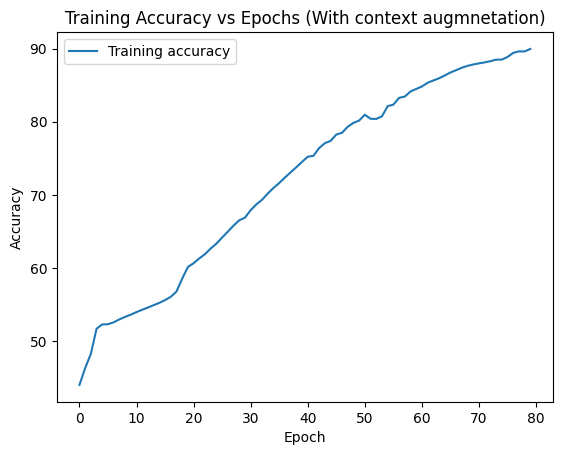

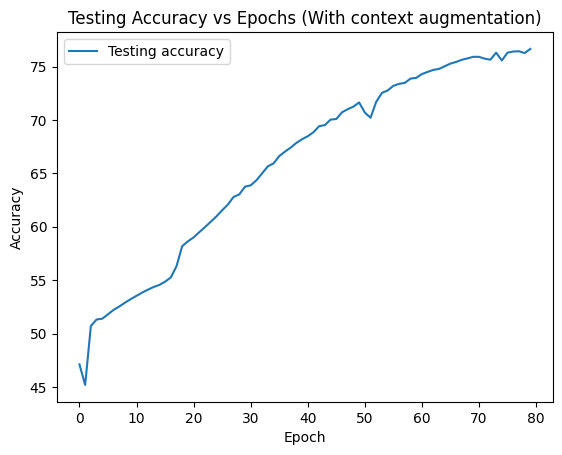

In [19]:

print("max training accuracy: ", max(traccs_c))
print("max testing accuracy: ", max(tsaccs_c))
lab = "Training accuracy"
plt.figure(1)
plt.plot(traccs_c, label=lab)
plt.title("Training Accuracy vs Epochs (With context augmnetation)")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
lab = "Testing accuracy"
plt.figure(2)
plt.plot(tsaccs_c, label=lab)
plt.title("Testing Accuracy vs Epochs (With context augmentation)")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

# Dropout
## Shallow model

In [ ]:
n_in = 768
n_out = 3
learning_rate = 0.001
K = 770
epochs = 80

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class Net(nn.Module):
    def __init__(self, K, p):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_in, K) 
        torch.nn.init.kaiming_uniform_(self.fc1.weight) #He initialization
        self.fc2 = nn.Linear(K, n_out)
        torch.nn.init.kaiming_uniform_(self.fc2.weight) #He initialization
        self.dropout = nn.Dropout(1-p)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = self.dropout(x)
        return x

#criterion = torch.nn.MSELoss()
criterion = nn.CrossEntropyLoss()

In [ ]:
all_traccs = []
all_tsaccs = []
P = [1.0, 0.5, 0.1]
for p in P:
    net = Net(K, p).to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    traccs = []
    tsaccs = []
    for epoch in range(epochs):
        correct = 0
        size = 0
        net.train()
        for b, (x, y) in enumerate(trainloader):
            x = x.to(device)
            y = y.to(device)

            optimizer.zero_grad() 
            output = net(x)
            cor = (output.argmax(1) == y).float().sum().item()

            correct += cor
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()

            size += len(x)

        traccs.append((100 * correct) / size)
        net.eval()
        correct = 0
        size = 0
        with torch.no_grad():
            for b, (x, y) in enumerate(testloader):
                x = x.to(device)
                y = y.to(device)

                optimizer.zero_grad() 
                output = net(x)
                #print(output)
                #acu += (output.argmax(1) == y).float().sum().item()
                cor = (output.argmax(1) == y).float().sum().item()

                correct += cor
                size += len(x)

            #accs.append(100 * (acu / len(y_tr)))
            tsaccs.append((100 * correct) / size)

        #if ((epoch+1) % 10) == 0:
            #print("Epoch: ", epoch+1)
    all_traccs.append(traccs)
    all_tsaccs.append(tsaccs)

In [ ]:
plt.figure(1)
for i, p in enumerate(P):
    plt.plot(all_traccs[i], label='p={}'.format(p))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Change in Training Accuracy')
plt.legend()
plt.show()

plt.figure(2)
for i, p in enumerate(P):
    plt.plot(all_tsaccs[i], label='p={}'.format(p))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Change in Testing Accuracy')
plt.legend()
plt.show()

In [ ]:
for i in range(3):
    print('training p = ', P[i], max(all_traccs[i]))
    print('test p = ', P[i], max(all_tsaccs[i]))

## Deep Network

In [ ]:
#deep neural network
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class DeepNet(nn.Module):
    def __init__(self, p):
        super(DeepNet, self).__init__()
        self.fc1 = nn.Linear(n_in, 770) 
        torch.nn.init.kaiming_uniform_(self.fc1.weight) #He initialization
        self.fc2 = nn.Linear(770, 700)
        torch.nn.init.kaiming_uniform_(self.fc2.weight) #He initialization
        self.fc3 = nn.Linear(700, 600) 
        torch.nn.init.kaiming_uniform_(self.fc3.weight) #He initialization
        self.fc4 = nn.Linear(600, 500)
        torch.nn.init.kaiming_uniform_(self.fc4.weight) #He initialization
        self.fc5 = nn.Linear(500, 400) 
        torch.nn.init.kaiming_uniform_(self.fc5.weight) #He initialization
        self.fc6 = nn.Linear(400, 300)
        torch.nn.init.kaiming_uniform_(self.fc6.weight) #He initialization
        self.fc7 = nn.Linear(300, 200) 
        torch.nn.init.kaiming_uniform_(self.fc7.weight) #He initialization
        self.fc8 = nn.Linear(200, 100)
        torch.nn.init.kaiming_uniform_(self.fc8.weight) #He initialization
        self.fc9 = nn.Linear(100, 50) 
        torch.nn.init.kaiming_uniform_(self.fc9.weight) #He initialization
        self.fc10 = nn.Linear(50, n_out)
        torch.nn.init.kaiming_uniform_(self.fc10.weight) #He initialization
        self.dropout = nn.Dropout(1-p)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = F.relu(self.fc7(x))
        x = F.relu(self.fc8(x))
        x = F.relu(self.fc9(x))
        x = F.sigmoid(self.fc10(x))
        x = self.dropout(x)
        return x

In [ ]:
all_deep_traccs = []
all_deep_tsaccs = []
for p in P:
    deepNet = DeepNet(p).to(device)
    optimizer = torch.optim.Adam(deepNet.parameters(), lr=learning_rate)
    deep_traccs = []
    deep_tsaccs = []
    for epoch in range(epochs):
        correct = 0
        size = 0
        deepNet.train()
        for b, (x, y) in enumerate(trainloader):
            x = x.to(device)
            y = y.to(device)

            optimizer.zero_grad() 
            output = deepNet(x)
            cor = (output.argmax(1) == y).float().sum().item()

            correct += cor
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()

            size += len(x)

        deep_traccs.append((100 * correct) / size)
        deepNet.eval()
        correct = 0
        size = 0
        with torch.no_grad():
            for b, (x, y) in enumerate(testloader):
                x = x.to(device)
                y = y.to(device)

                optimizer.zero_grad() 
                output = deepNet(x)
                cor = (output.argmax(1) == y).float().sum().item()

                correct += cor
                size += len(x)

            deep_tsaccs.append((100 * correct) / size)

    all_deep_traccs.append(deep_traccs)
    all_deep_tsaccs.append(deep_tsaccs)

In [ ]:
plt.figure(1)
for i, p in enumerate(P):
    plt.plot(all_deep_traccs[i], label='p={}'.format(p))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Change in Training Accuracy')
plt.legend()
plt.show()

plt.figure(2)
for i, p in enumerate(P):
    plt.plot(all_deep_tsaccs[i], label='p={}'.format(p))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Change in Testing Accuracy')
plt.legend()
plt.show()

In [ ]:
for i in range(3):
    print('training p = ', P[i], max(all_deep_traccs[i]))
    print('test p = ', P[i], max(all_deep_tsaccs[i]))